### Load Modules

In [1]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.fem_utils_HC import *
from src.codes.utils.plot_files.plot_utils import TwoDPlot as plot
from src.codes.utils.rom_utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation
import src.codes.reductor.rom_class_ms as rom_class
import src.codes.algorithms.deim as deim_module
from importlib import reload
reload(deim_module)
import ptitprince as pt
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 100

### Load data

In [3]:
filename_dataC = 'examples/heat_conduction/TwoD_heat_conduction/data/DataClass.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask

N_snap,_ = np.shape(NLS)
print(N_snap)

eval_rom = True

100


### Plot data

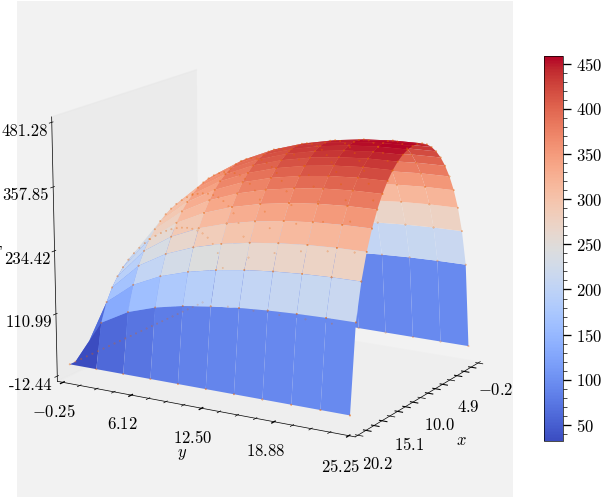

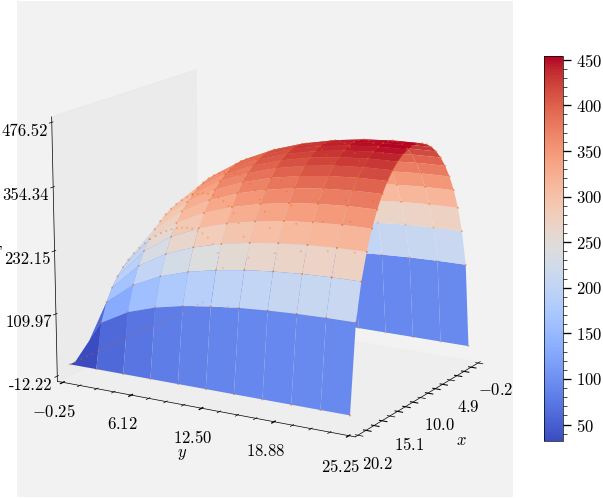

In [4]:
for i in range(2):
    Plot = plot(d.xi[0], d.xi[1], NLS[i])
    Plot.surface_()
plt.show()

## DEIM Hyper-reduction

### Train-Test split

In [5]:
# train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask][:,d.mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask][:,d.mask]

### Mean Subtraction

In [6]:
NLS_train_mean = np.mean(NLS_train,axis=0)
NLS_train_mean.shape
NLS_train_ms = NLS_train - NLS_train_mean


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 3


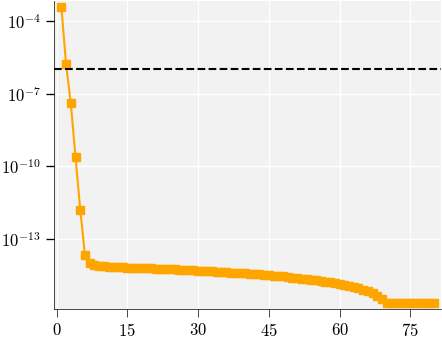

In [7]:
# plt.rcParams['figure.dpi'] = 100*2
n_sel, U = svd_mode_selector(NLS_train, tolerance=1e-6,modes=True)
V_sel = U[:, :n_sel]

In [8]:
# for i in range(n_sel):
#     plot(d.xi[0], d.xi[1], V_sel[:,i],elev=15, azim=60).surface_()

### Step 2: Perform SVD on the force snapshots

Selected modes:1


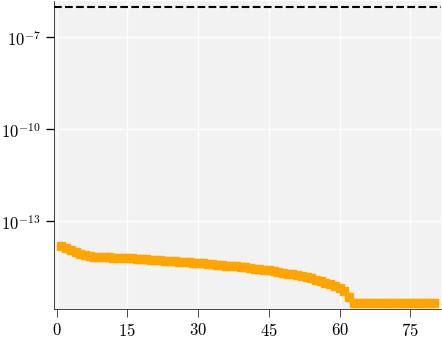

In [9]:
# Force snapshots
F_nl = np.asarray(Data_cls.rhs)
deim = deim_module.deim(d,F_nl,train_mask,param_list,V_sel,NLS_train_ms,d.mask,tol_f=1e-6, extra_modes=0)

tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()

xi = deim.xi

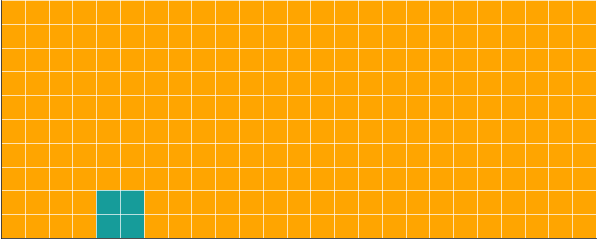

Fraction of total elements active in the ROM: 1.6%


In [10]:
plot(0,0,0).element_((d.ncells[0],d.ncells[1]), xi, d.ncells)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

### Specifiy the subtracted mean

In [11]:
Data_cls.mean = NLS_train_mean


### ROM Simulation

In [12]:
ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi, deim=deim)#, N_rom_snap=1)
ROM_h.run_simulation_h_deim();

In [13]:
eval_rom = True
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi)#, N_rom_snap=1)
    ROM.run_simulation()

### Performance Statistics

In [14]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

In [15]:
if eval_rom:
    NLS_rom = np.asarray(ROM.NL_solutions_rom)
    ROM_speed_up = ROM.speed_up
    ROM_relative_error = ROM.rom_error

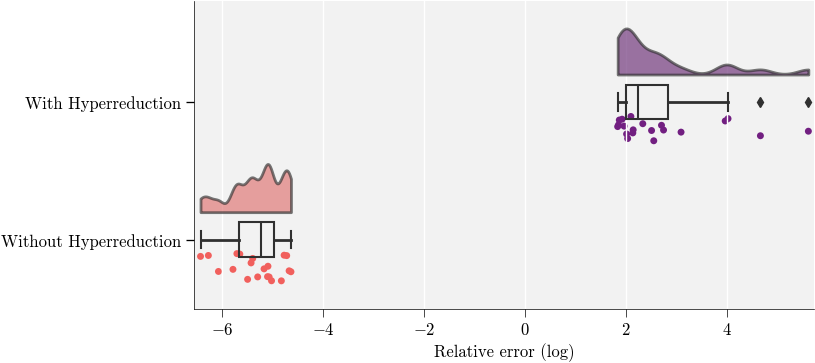

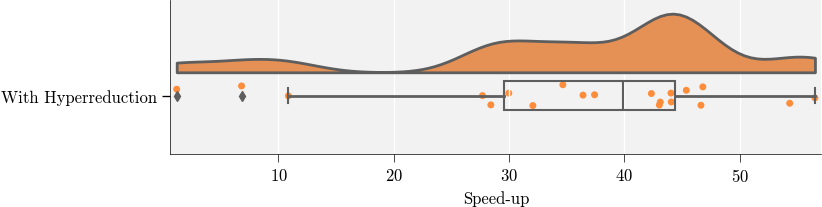

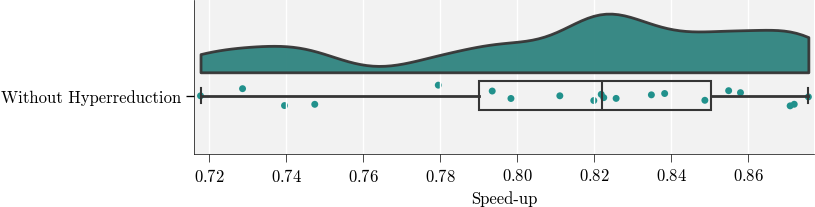

In [16]:
df_A = pd.DataFrame({'':'With Hyperreduction','Relative error (log)':np.log10(ROM_relative_error_h)})
df_B = pd.DataFrame({'':'Without Hyperreduction','Relative error (log)':np.log10(ROM_relative_error)})

# Combine the DataFrames
df = pd.concat([df_A, df_B])

fig, ax = plt.subplots(figsize=(8, 4))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df, palette = "magma", bw = 0.2,
    width_viol = .7, ax = ax, orient = "h",pointplot = False, dodge=False, alpha=0.65, width_box = 0.25, linewidth=2, point_size =5.0, move=0.2)
plt.show()

# ===

df_C = pd.DataFrame({'':'With Hyperreduction','Speed-up':ROM_speed_up_h})
df_D = pd.DataFrame({'':'Without Hyperreduction','Speed-up':ROM_speed_up})

# Combine the DataFrames
df2 = pd.concat([df_C, df_D])

fig, ax = plt.subplots(figsize=(8.4, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_C, palette = "Oranges",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0)

fig, ax = plt.subplots(figsize=(8, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "viridis",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=0.95, width_box = 0.25, linewidth=2, point_size =5.0)
plt.show()